In [1]:
# necessary imports
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")
import wrangle as wra
import env
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

In [2]:
zillow_query = """
        select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt,
        taxamount, fips
        from properties_2017
        where propertylandusetypeid = '261';
        """

zillow_df = wra.get_zillow_data(zillow_query)

zillow_df.head()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
df = zillow_df

In [4]:
df = wra.wrangle_zillow(df)

In [5]:
df.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
4,4,2.0,3633,296425,2005,6941.39,LA
6,3,4.0,1620,847770,2011,10244.94,LA
7,3,2.0,2077,646760,1926,7924.68,LA
11,0,0.0,1200,5328,1972,91.60,LA
14,0,0.0,171,6920,1973,255.17,LA


In [6]:
train, validate, test = wra.split_data(df)

In [40]:
print (f'''{train.shape}
{validate.shape}
{test.shape}''')

(1219902, 7)
(406635, 7)
(406635, 7)


In [7]:
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
1571798,4,2.5,2987,885000,2006,13617.38,Orange
1723553,3,2.0,3013,489511,1977,5768.57,LA
718174,4,3.0,2572,390915,1986,4944.11,LA
1663205,3,1.0,1589,321758,1959,4031.78,LA
1087891,3,2.0,1727,231737,1962,2708.80,Ventura


In [8]:
train.describe()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount
count,1.219902e+06,1.219902e+06,1.219902e+06,1.219902e+06,1.219902e+06,1.219902e+06
mean,3.258273e+00,2.141407e+00,1.751959e+03,3.635321e+05,1.960259e+03,4.509706e+03
std,8.974253e-01,8.354628e-01,7.260309e+02,2.432958e+05,2.155127e+01,2.845417e+03
min,0.000000e+00,0.000000e+00,1.000000e+00,2.200000e+01,1.801000e+03,1.336000e+01
25%,3.000000e+00,2.000000e+00,1.242000e+03,1.818500e+05,1.949000e+03,2.458920e+03
50%,3.000000e+00,2.000000e+00,1.587000e+03,3.130040e+05,1.958000e+03,3.941860e+03
75%,4.000000e+00,3.000000e+00,2.108000e+03,4.923168e+05,1.974000e+03,5.943167e+03
max,1.600000e+01,2.000000e+01,2.280000e+04,1.202999e+06,2.016000e+03,1.003793e+05


X_train, X_validate = train[['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount']], validate[['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount']]

y_train, y_validate = train.taxvalue, validate.taxvalue

scaler = MinMaxScaler()
train[['bedroomcnt_minmax', 'bathroomcnt_minmax', 'squarefeet_minmax', 'yearbuilt_minmax', 'taxamount_minmax']] = scaler.fit_transform(train[['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount']])


scaler = StandardScaler()
train[['bedroomcnt_standard', 'bathroomcnt_standard', 'squarefeet_standard', 'yearbuilt_standard', 'taxamount_standard']] = scaler.fit_transform(train[['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount']])


In [ ]:
scaler = RobustScaler()
train[['bedroomcnt_robust', 'bathroomcnt_robust', 'squarefeet_robust', 'yearbuilt_robust', 'taxamount_robust']] = scaler.fit_transform(train[['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount']])


train[sorted(train)]

### Apply the scalers we talked about in this lesson to your data and visualize the results for the unscaled and scaled distribution.

In [10]:
def visualize_scaler(scaler, df, columns_to_scale, bins=10):
    #create subplot structure
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(12,12))

    #copy the df for scaling
    df_scaled = df.copy()
    
    #fit and transform the df
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    #plot the pre-scaled data next to the post-scaled data in one row of a subplot
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()

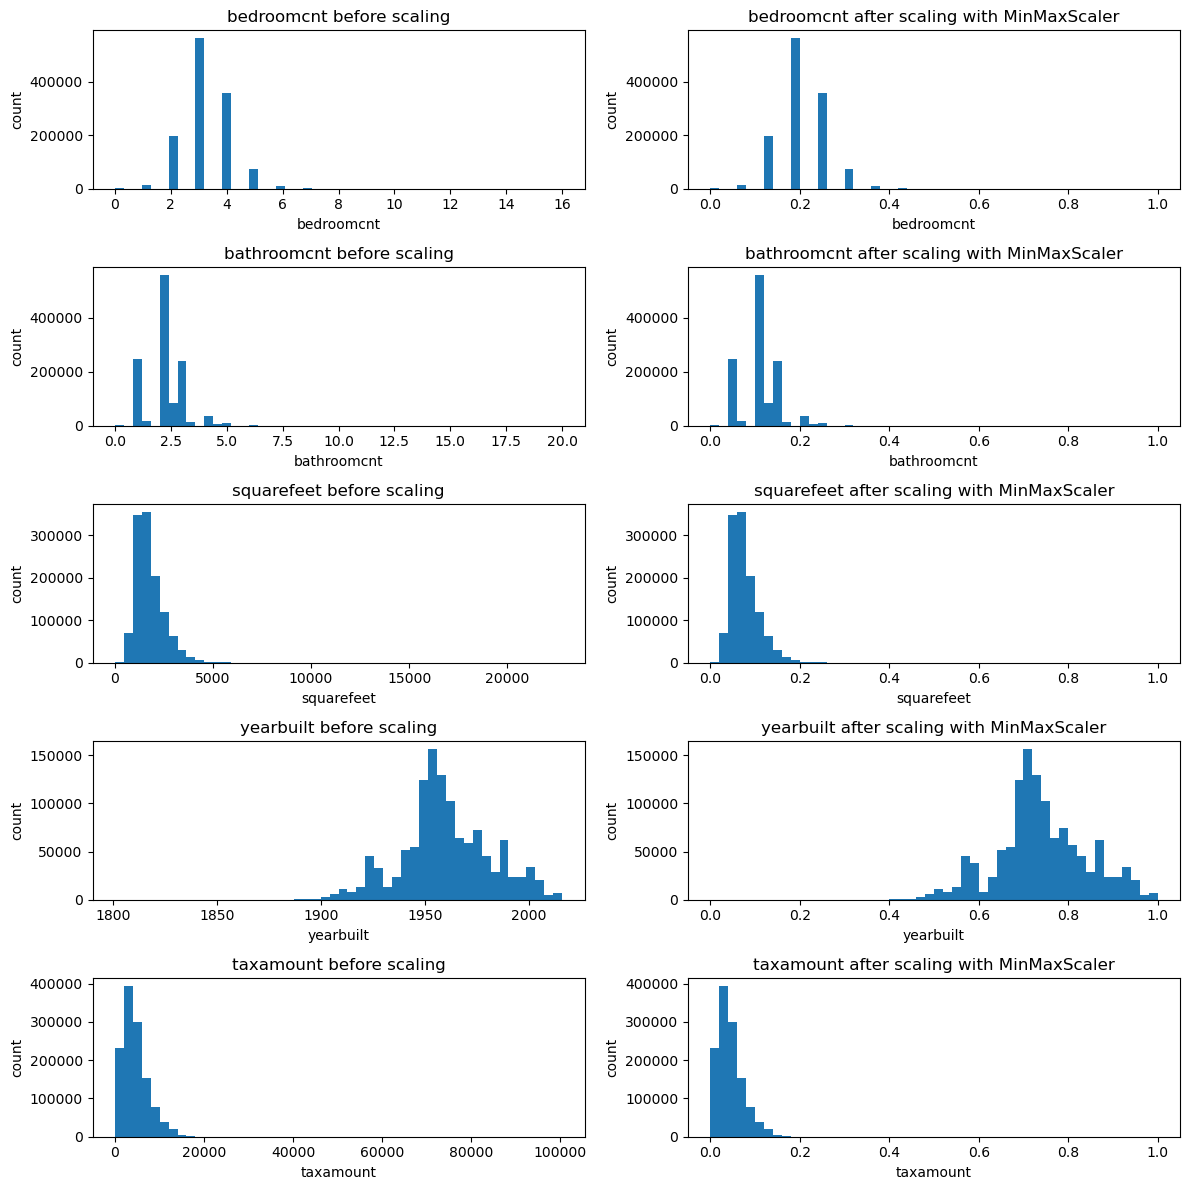

In [11]:
# call function with minmax
visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

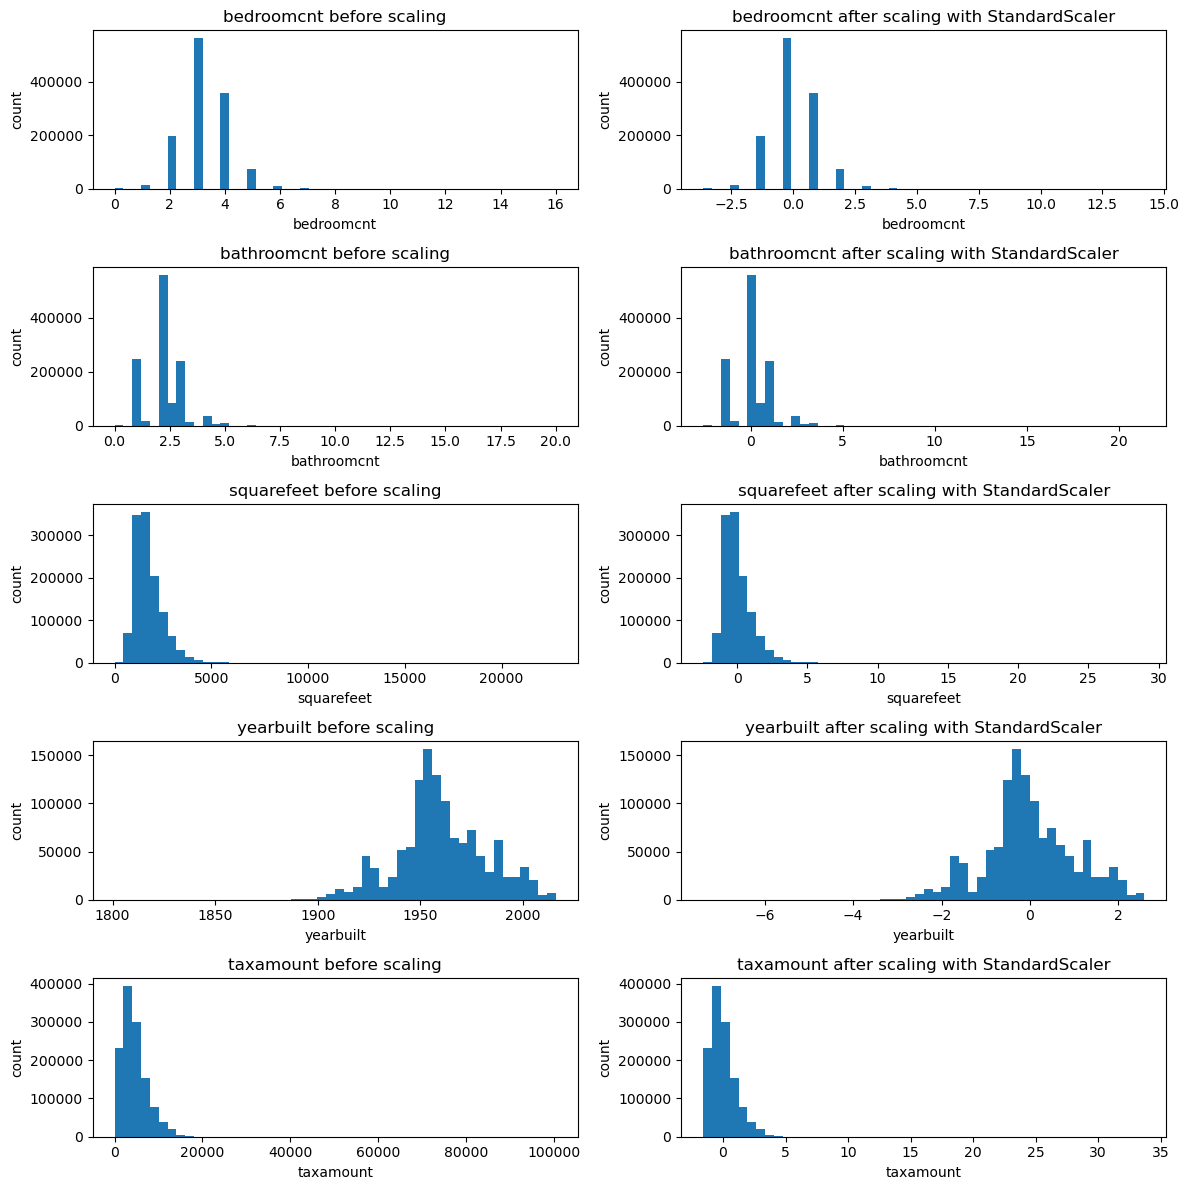

In [12]:
# call function with standard scaler
visualize_scaler(scaler=StandardScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

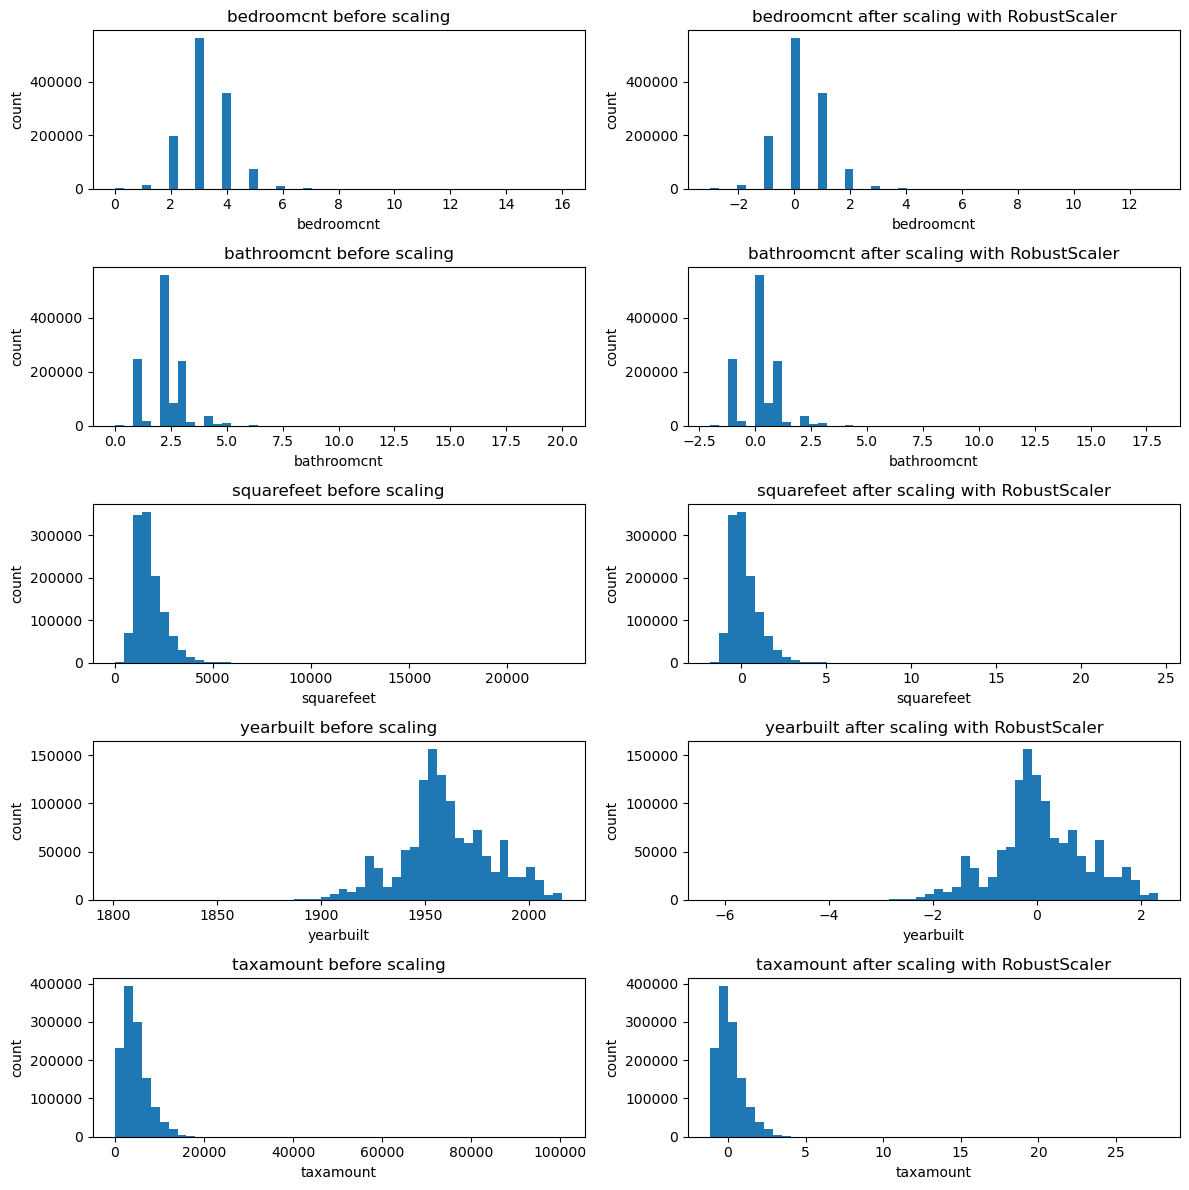

In [13]:
# call function with robustscaler
visualize_scaler(scaler=RobustScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

In [14]:
#look at original data
train[to_scale].head()

,bedroomcnt,bathroomcnt,squarefeet,yearbuilt,taxamount
1571798,4,2.5,2987,2006,13617.38
1723553,3,2.0,3013,1977,5768.57
718174,4,3.0,2572,1986,4944.11
1663205,3,1.0,1589,1959,4031.78
1087891,3,2.0,1727,1962,2708.80


In [15]:
#make it
scaler = MinMaxScaler()

#fit and use it
train_scaled = scaler.fit_transform(train[to_scale])

#convert to df
train_scaled = pd.DataFrame(train_scaled, columns=to_scale)

In [16]:
#look at scaled data
train_scaled.head()

,bedroomcnt,bathroomcnt,squarefeet,yearbuilt,taxamount
0,0.2500,0.125,0.130971,0.953488,0.135544
1,0.1875,0.100,0.132111,0.818605,0.057342
2,0.2500,0.150,0.112768,0.860465,0.049128
3,0.1875,0.050,0.069652,0.734884,0.040038
4,0.1875,0.100,0.075705,0.748837,0.026856


### Apply the .inverse_transform method to your scaled data. Is the resulting dataset the exact same as the original data?

In [17]:
#appling the inverse_transform function to the scaled data
inverse_train_scaled = scaler.inverse_transform(train_scaled)
inverse_train_scaled

array([[4.000000e+00, 2.500000e+00, 2.987000e+03, 2.006000e+03,
        1.361738e+04],
       [3.000000e+00, 2.000000e+00, 3.013000e+03, 1.977000e+03,
        5.768570e+03],
       [4.000000e+00, 3.000000e+00, 2.572000e+03, 1.986000e+03,
        4.944110e+03],
       ...,
       [3.000000e+00, 3.000000e+00, 1.841000e+03, 1.955000e+03,
        1.731150e+03],
       [3.000000e+00, 2.000000e+00, 1.406000e+03, 1.956000e+03,
        4.559860e+03],
       [3.000000e+00, 1.000000e+00, 1.571000e+03, 1.948000e+03,
        2.619670e+03]])

In [18]:
#converting 2d array to df and adding column names
pd.DataFrame(inverse_train_scaled, columns=to_scale)

,bedroomcnt,bathroomcnt,squarefeet,yearbuilt,taxamount
0,4.0,2.5,2987.0,2006.0,13617.38
1,3.0,2.0,3013.0,1977.0,5768.57
2,4.0,3.0,2572.0,1986.0,4944.11
3,3.0,1.0,1589.0,1959.0,4031.78
4,3.0,2.0,1727.0,1962.0,2708.80
...,...,...,...,...,...
1219897,3.0,2.0,1610.0,1984.0,3001.96
1219898,2.0,1.0,900.0,1938.0,3323.92
1219899,3.0,3.0,1841.0,1955.0,1731.15
1219900,3.0,2.0,1406.0,1956.0,4559.86


## Read the documentation for sklearn's QuantileTransformer. Use normal for the output_distribution and apply this scaler to your data. Visualize the result of your data scaling.
* This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme

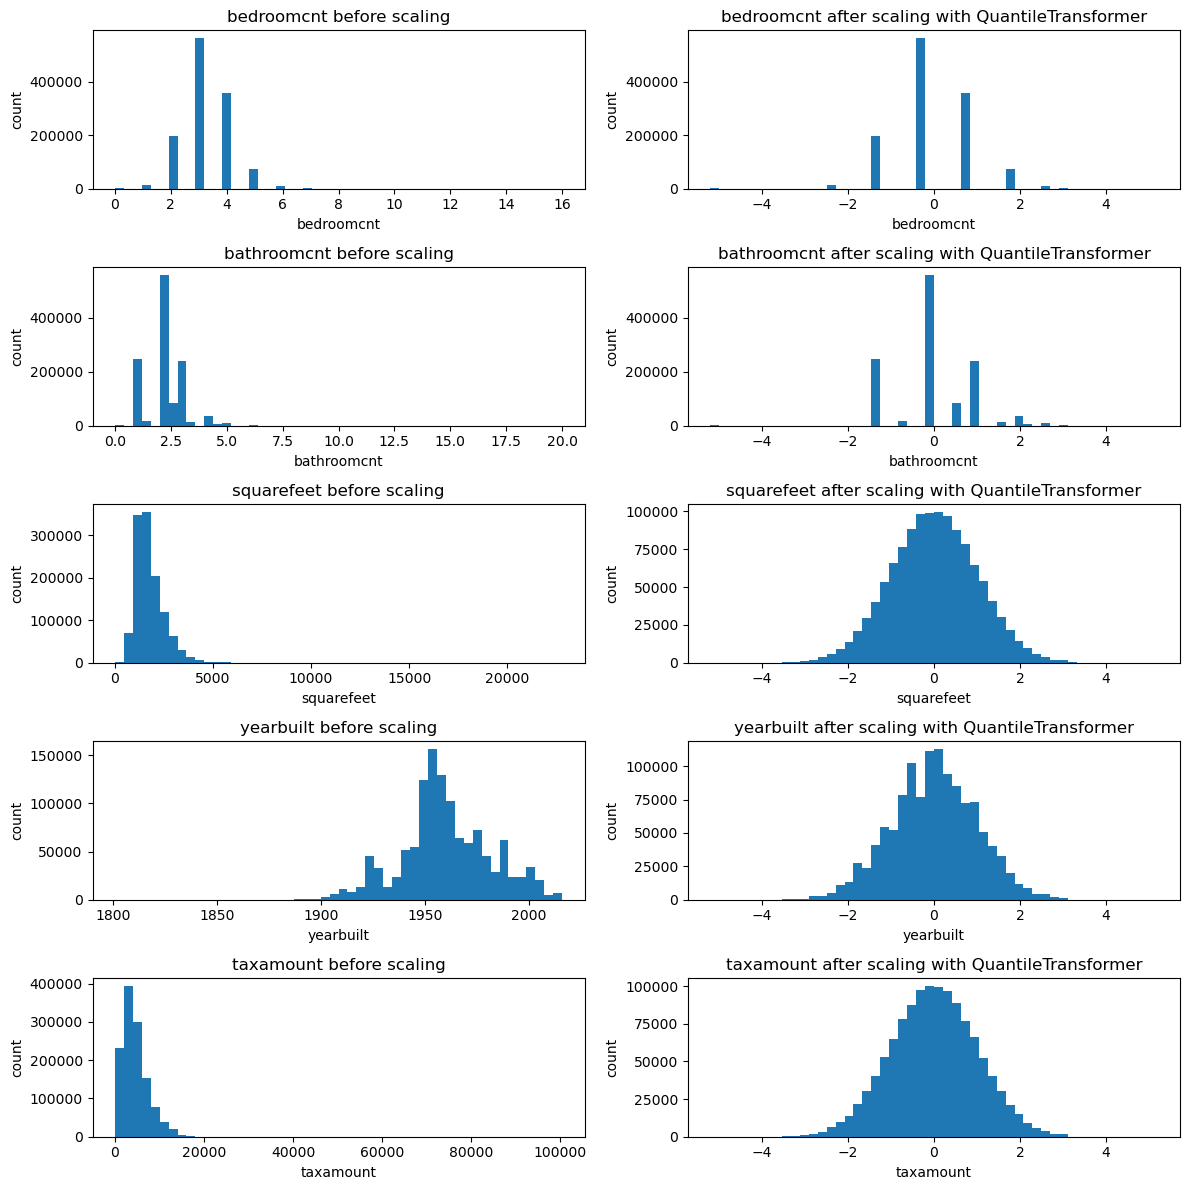

In [19]:
# call function using QuantileTransformer
visualize_scaler(scaler=QuantileTransformer(output_distribution='normal'), 
                 df=train,
                 columns_to_scale=to_scale, 
                 bins=50)

## Use the QuantileTransformer, but omit the output_distribution argument. Visualize your results. What do you notice?

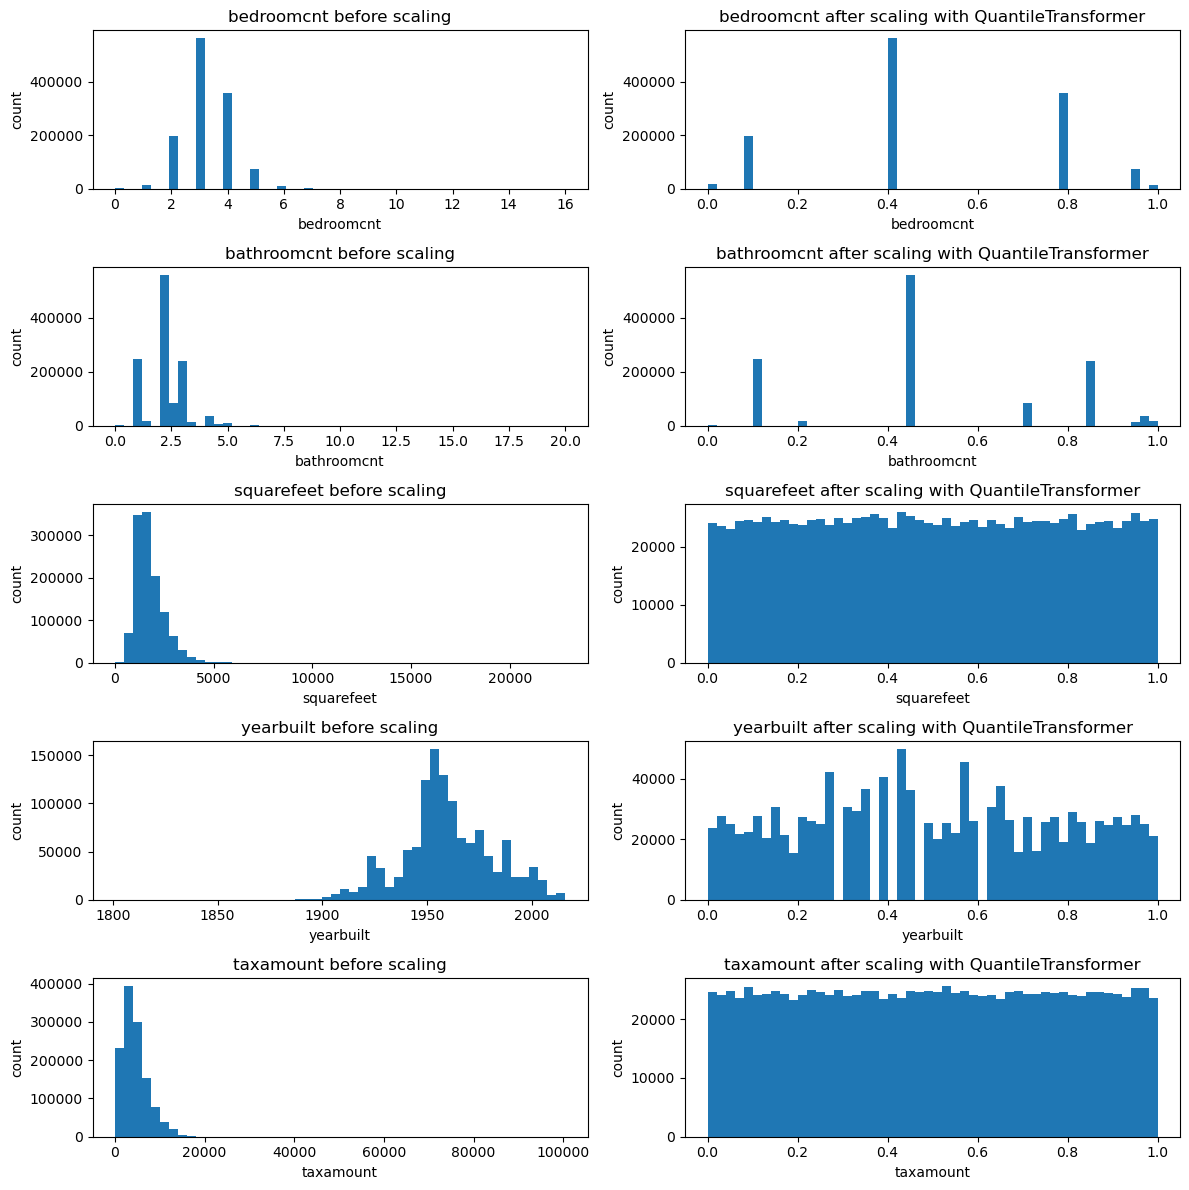

In [20]:
# call function using QuantileTransformer
visualize_scaler(scaler=QuantileTransformer(), 
                 df=train,
                 columns_to_scale=to_scale, 
                 bins=50)

### Based on the work you've done, choose a scaling method for your dataset. Write a function within your prepare.py that accepts as input the train, validate, and test data splits, and returns the scaled versions of each. Be sure to only learn the parameters for scaling from your training data!

In [21]:
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
1571798,4,2.5,2987,885000,2006,13617.38,Orange
1723553,3,2.0,3013,489511,1977,5768.57,LA
718174,4,3.0,2572,390915,1986,4944.11,LA
1663205,3,1.0,1589,321758,1959,4031.78,LA
1087891,3,2.0,1727,231737,1962,2708.80,Ventura


In [22]:
to_scale

['bedroomcnt', 'bathroomcnt', 'squarefeet', 'yearbuilt', 'taxamount']

In [23]:
def scale_data(train, 
               validate, 
               test, 
               to_scale):
    #make copies for scaling
    train_scaled = train.copy()
    validate_scaled = test.copy()
    test_scaled = test.copy()

    #scale them!
    #make the thing
    scaler = MinMaxScaler()

    #fit the thing
    scaler.fit(train[to_scale])

    #use the thing
    train_scaled[to_scale] = scaler.transform(train[to_scale])
    validate_scaled[to_scale] = scaler.transform(validate[to_scale])
    test_scaled[to_scale] = scaler.transform(test[to_scale])
    
    return train_scaled, validate_scaled, test_scaled

In [24]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, to_scale)

In [25]:
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
1571798,4,2.5,2987,885000,2006,13617.38,Orange
1723553,3,2.0,3013,489511,1977,5768.57,LA
718174,4,3.0,2572,390915,1986,4944.11,LA
1663205,3,1.0,1589,321758,1959,4031.78,LA
1087891,3,2.0,1727,231737,1962,2708.80,Ventura


In [26]:
train_scaled.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
1571798,0.2500,0.125,0.130971,885000,0.953488,0.135544,Orange
1723553,0.1875,0.100,0.132111,489511,0.818605,0.057342,LA
718174,0.2500,0.150,0.112768,390915,0.860465,0.049128,LA
1663205,0.1875,0.050,0.069652,321758,0.734884,0.040038,LA
1087891,0.1875,0.100,0.075705,231737,0.748837,0.026856,Ventura


### What do I want to explore on?
### What do I want to use for modeling?

In [27]:
train_preprocessed = train_scaled.drop(columns=['county'])

In [28]:
train_preprocessed.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount
1571798,0.2500,0.125,0.130971,885000,0.953488,0.135544
1723553,0.1875,0.100,0.132111,489511,0.818605,0.057342
718174,0.2500,0.150,0.112768,390915,0.860465,0.049128
1663205,0.1875,0.050,0.069652,321758,0.734884,0.040038
1087891,0.1875,0.100,0.075705,231737,0.748837,0.026856


# Exploration

### 1. As with encoded vs. unencoded data, we recommend exploring un-scaled data in your EDA process.

### 2. Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

### 3. Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [29]:
# train = train.drop(columns=['county'])

In [32]:
def plot_variable_pairs(df):
    sns.pairplot(df, corner=True, kind='reg')
    plt.show()

In [33]:
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
1571798,4,2.5,2987,885000,2006,13617.38,Orange
1723553,3,2.0,3013,489511,1977,5768.57,LA
718174,4,3.0,2572,390915,1986,4944.11,LA
1663205,3,1.0,1589,321758,1959,4031.78,LA
1087891,3,2.0,1727,231737,1962,2708.80,Ventura


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1219902 entries, 1571798 to 1587454
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   bedroomcnt   1219902 non-null  int64  
 1   bathroomcnt  1219902 non-null  float64
 2   squarefeet   1219902 non-null  int64  
 3   taxvalue     1219902 non-null  int64  
 4   yearbuilt    1219902 non-null  int64  
 5   taxamount    1219902 non-null  float64
 6   county       1219902 non-null  object 
dtypes: float64(2), int64(4), object(1)
memory usage: 106.7+ MB


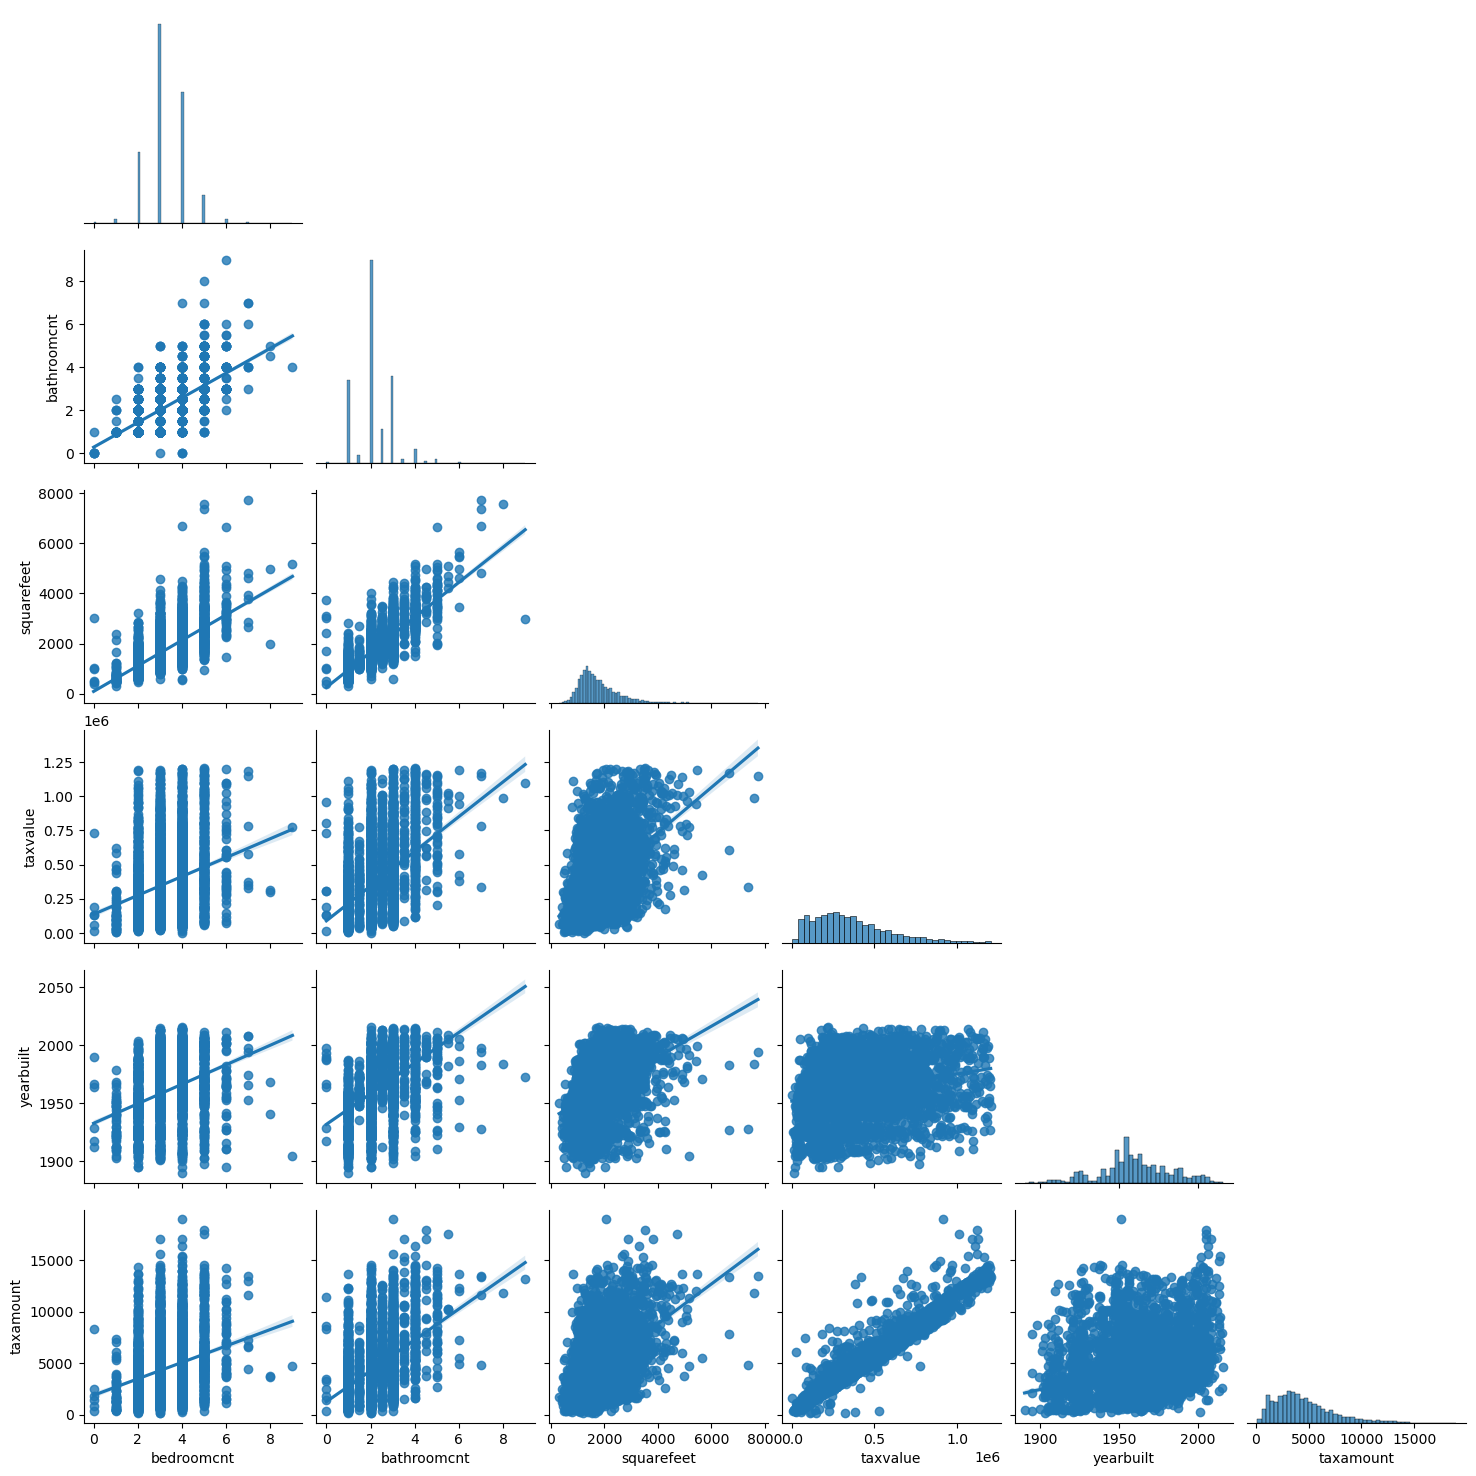

In [35]:
sns.pairplot(train.sample(5000), corner=True, kind='reg')
plt.show()

In [41]:
sns.pairplot(train, corner=True, kind='reg')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x139b2a9d0> (for post_execute):



KeyboardInterrupt



In [33]:
plot_variable_pairs(train)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x13cd219d0> (for post_execute):


KeyboardInterrupt: 

### 4. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [35]:
def plot_categorical_and_continuous_vars(df, cont_var, cat_var):
    # Plot a boxplot of the continuous variable for each category
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=cat_var, y=cont_var, data=df)
    plt.title(f'{cont_var} by {cat_var}')
    plt.show()
    
        # Plot a violinplot of the continuous variable for each category
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=cat_var, y=cont_var, data=df)
    plt.title(f'{cont_var} by {cat_var}')
    plt.show()

    # Plot a swarmplot of the continuous variable for each category
    plt.figure(figsize=(8, 6))
    sns.swarmplot(x=cat_var, y=cont_var, data=df)
    plt.title(f'{cont_var} by {cat_var}')
    plt.show()

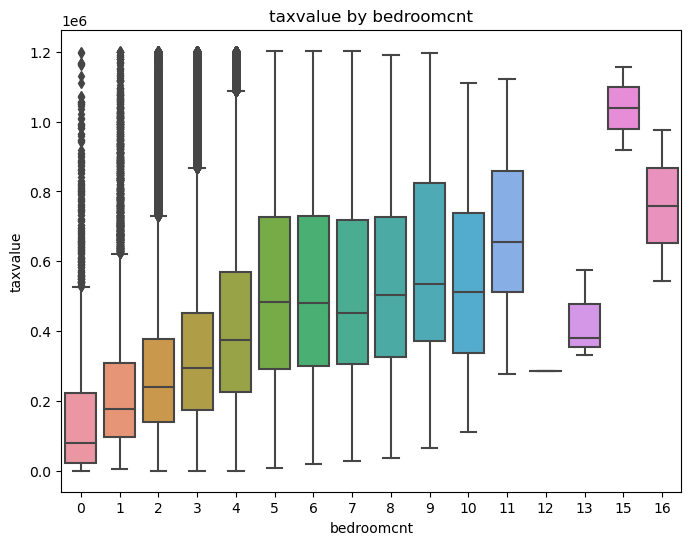

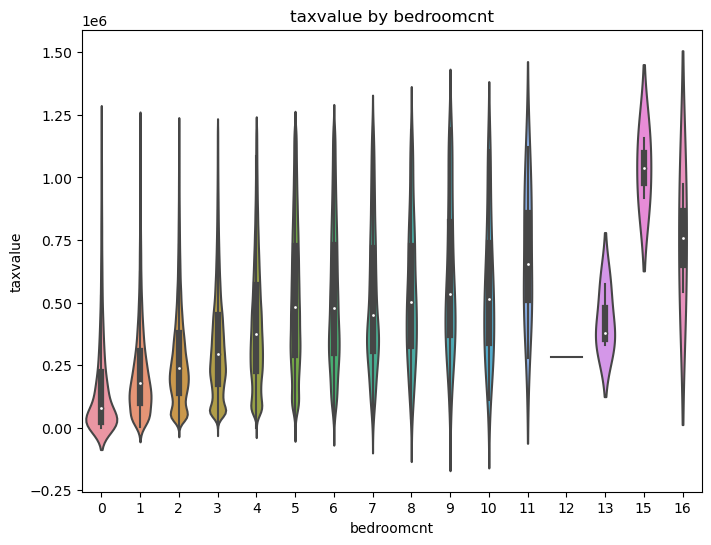

In [ ]:
plot_categorical_and_continuous_vars(train, 'taxvalue', 'bedroomcnt')

### Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.